# Deep learning classifiers for urban sound data - Project Machine Learning II

## Índice
1. Imports and Setup
2. Data exploration
3. Data pre-processing and preparation
4. Model architecture definition
5. Training strategies
6. Performance evaluation 

#### 1. Import and Setup

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import librosa
import IPython.display as ipd
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix  
from sklearn.preprocessing import StandardScaler
import itertools
import pandas as pd


#### 2. Data exploration

Antes de definir o _pipeline_ de pré-processamento e os modelos de _deep learning_,
é importante compreender a estrutura do UrbanSound8K. Em particular, interessa-nos:

- quantos exemplos existem no total;
- como estão distribuídos pelas diferentes classes;
- de que forma os `folds` 1–10 pré-definidos pelo dataset afectam essa distribuição.


In [3]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
print("The dataset contains:", df.shape, "rows and columns.") 
df.head()

The dataset contains: (8732, 8) rows and columns.


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


O ficheiro `UrbanSound8K.csv` contém, para cada excerto de áudio:

- o **nome do ficheiro** (`slice_file_name`);
- o **fold** (`fold`) a que pertence (de 1 a 10), que será usado na _cross-validation_;
- o **identificador numérico** da classe (`classID`);
- a **etiqueta textual** da classe (`class`), por exemplo `dog_bark`, `siren`, `jackhammer`.
- o **salience** representa a saliência do som, é 1 quando está destacado e 2 quando tem mais barulho de fundo.
- o **fsID**, **start** e **end** contém infromação sobre o aúdio original que não iremos utilizar.

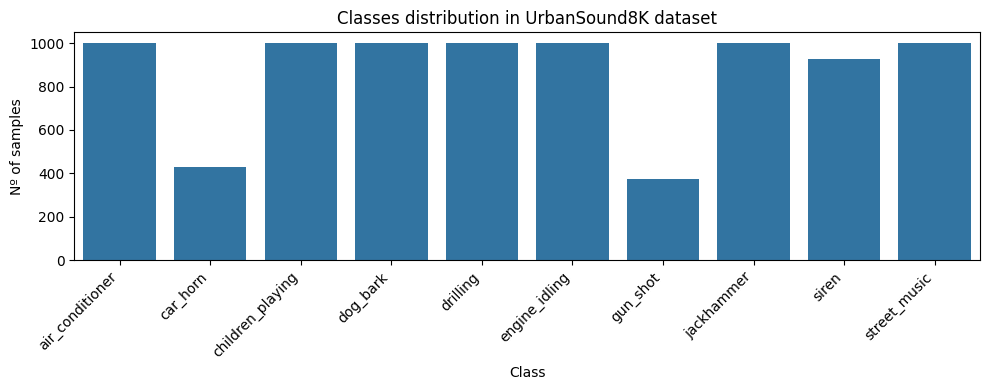

In [4]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="class", order=sorted(df["class"].unique()))
ax.set_title("Classes distribution in UrbanSound8K dataset")
ax.set_xlabel("Class"); ax.set_ylabel("Nº of samples")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.show()

A Figura acima mostra o número de exemplos em cada uma das 10 classes do UrbanSound8K.

Observa-se que:

- a maioria das classes tem cerca de 1000 exemplos, sem grandes
  assimetrias extremas;
- ainda assim, classes como **car_horn** e **gun_shot** apresentam um número
  visivelmente inferior de amostras.

Isto decorre do próprio desenho do UrbanSound8K, que não é perfeitamente balanceado entre classes. Assim, as classes minoritárias
tenderão a ser mais difíceis de aprender e os modelos podem ficar ligeiramente
enviesados para as classes mais frequentes.

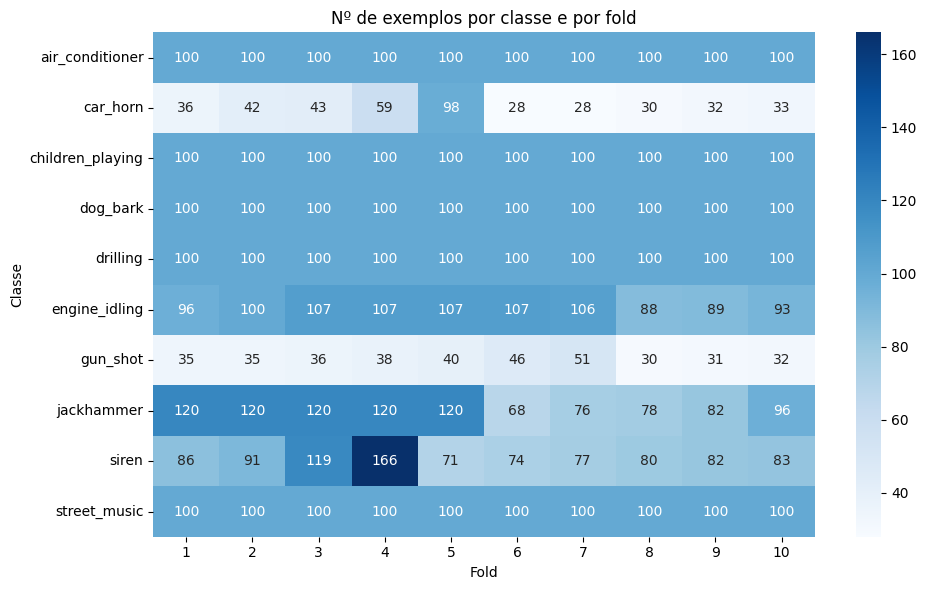

In [5]:
# Tabela fold x classe
counts = df.groupby(["class", "fold"]).size().unstack("fold").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(counts, annot=True, fmt=".0f", cmap="Blues")
plt.title("Nº de exemplos por classe e por fold")
plt.xlabel("Fold")
plt.ylabel("Classe")
plt.tight_layout()
plt.show()



Podemos concluir do gráfico acima que exitem:
- Classes quase perfeitas: air_conditioner, children_playing, dog_bark, drilling, street_music com 100 exemplos por fold.

- Classes com pequenas oscilações: engine_idling, gun_shot, que variam de forma pouco drástica.

- Classes com oscilações fortes:
    - car_horn: de 28 a 98 por fold;
    - jackhammer: de 68 a 120 (e sempre alto nos primeiros folds);
    - siren: de 71 a 166 (em que o fold 4 tem maior representação).

Perguntei ao professor e ele disse que de facto este é um problema que ainda está aberto na área e que podemos meter na conslusão que de facto o modelo tem uma pior performance nas classes com menos representação e que future work seria usar estratégias como SMOTE para class imbalance.

- escolher métricas adequadas (por exemplo, *per-class accuracy* ou *macro F1*);
- usar, se necessário, técnicas como **class weighting** ou **data augmentation** nas classes
  minoritárias;



#### 3. Data pre-processing and preparation

Nesta secção definimos o _pipeline_ de pré-processamento de áudio que será usado para alimentar os classificadores _deep learning_. Em particular, vamos:

- garantir que todos os clipes de áudio têm a mesma duração e frequência de amostragem;
- extrair duas representações distintas do som:
  - **log-mel-spectrogramas 2D**, adequados para redes convolucionais (CNN);
  - **vetores de MFCCs agregados**, adequados para redes totalmente ligadas (MLP);
- preparar funções auxiliares que mais tarde serão integradas nos `Dataset`/`DataLoader` de treino, validação e teste;
- definir, desde já, funções de *data augmentation* (aplicadas apenas em treino) que permitem aumentar a variabilidade dos exemplos. !!!Confirmar com o professor.

Estas etapas garantem que os modelos recebem entradas com dimensão fixa e características informativas, mantendo a consistência entre os diferentes folds do UrbanSound8K.


##### 3.1. Caminhos e parâmetros globais de áudio

In [6]:
AUDIO_DIR = "./UrbanSound8K/audio"  # diretório base dos ficheiros .wav

# Parâmetros de áudio
SAMPLE_RATE = 22050   # Hz (frequência de amostragem alvo)
DURATION = 4.0        # segundos (duração alvo de cada clipe)
N_MELS = 64           # nº de bandas mel (para a CNN)
N_MFCC = 20           # nº de coeficientes MFCC (para a MLP)

# Número de amostras por clipe (waveform) após corte/padding
SAMPLES_PER_CLIP = int(SAMPLE_RATE * DURATION)

def get_audio_path(row):
    """
    Dada uma linha do DataFrame df (UrbanSound8K.csv),
    devolve o caminho completo para o ficheiro .wav correspondente.
    """
    fold = row["fold"]
    filename = row["slice_file_name"]
    return os.path.join(AUDIO_DIR, f"fold{fold}", filename)


##### 3.2. Carregamento de áudio com duração fixa

O UrbanSound8K contém clipes com durações variáveis. No entanto, as redes neuronais
esperam tensores de entrada com dimensão fixa. Assim, definimos uma função que:

1. carrega o áudio com uma frequência de amostragem fixa (`SAMPLE_RATE`);
2. corta o sinal se for maior do que a duração alvo (`DURATION`);
3. aplica *zero-padding* se o sinal for mais curto.

Desta forma, todos os exemplos são representados por `SAMPLES_PER_CLIP` amostras.


In [7]:
def load_fixed_audio(path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """
    Carrega um ficheiro de áudio (.wav) e devolve sempre o mesmo número de samples.
    - se o clipe for maior do que `duration`: é cortado;
    - se for menor: é aplicado zero-padding no fim.
    """
    # Carregar áudio (librosa reamostra automaticamente para `sample_rate`, se necessário)
    y, sr = librosa.load(path, sr=sample_rate)

    target_len = int(sample_rate * duration)

    if len(y) > target_len:
        # cortar (aqui cortamos do início; poderíamos também cortar do centro)
        y = y[:target_len]
    elif len(y) < target_len:
        # padding com zeros no fim
        pad_width = target_len - len(y)
        y = np.pad(y, (0, pad_width))

    return y.astype(np.float32)


##### 3.2.1. Efeito da reamostragem e normalização da duração

Antes de alimentar os modelos, todos os clipes de áudio são:

1. **Reamostrados** para uma frequência de amostragem fixa (`SAMPLE_RATE`), garantindo
   que todos os exemplos têm o mesmo número de amostras por segundo;
2. **Normalizados em duração** para `DURATION` segundos, cortando o excesso ou
   aplicando *zero-padding* se forem mais curtos.

Para ilustrar o impacto destas transformações, comparamos abaixo o mesmo clipe
antes e depois do pré-processamento:
- waveform original vs waveform normalizado;
- parâmetros (frequência de amostragem e duração);


In [8]:
# Escolher um exemplo do DataFrame
row = df.iloc[0]
path = get_audio_path(row)
print("Ficheiro de exemplo:", path)

# --- Áudio original (como vem no ficheiro) ---
y_orig, sr_orig = librosa.load(path, sr=None)  # sr=None -> não reamostra

dur_orig = len(y_orig) / sr_orig
print(f"Original - sr: {sr_orig} Hz, n_amostras: {len(y_orig)}, duração: {dur_orig:.2f} s")

# --- Áudio processado (reamostrado + duração fixa) ---
y_proc = load_fixed_audio(path, sample_rate=SAMPLE_RATE, duration=DURATION)

dur_proc = len(y_proc) / SAMPLE_RATE
print(f"Processado - sr: {SAMPLE_RATE} Hz, n_amostras: {len(y_proc)}, duração: {dur_proc:.2f} s")

# Ouvir ambos (cuidado com o volume)
print("\nÁudio original:")
display(ipd.Audio(y_orig, rate=sr_orig))

print("Áudio processado (reamostrado + duração fixa):")
display(ipd.Audio(y_proc, rate=SAMPLE_RATE))


Ficheiro de exemplo: ./UrbanSound8K/audio\fold5\100032-3-0-0.wav
Original - sr: 44100 Hz, n_amostras: 14004, duração: 0.32 s
Processado - sr: 22050 Hz, n_amostras: 88200, duração: 4.00 s

Áudio original:


Áudio processado (reamostrado + duração fixa):


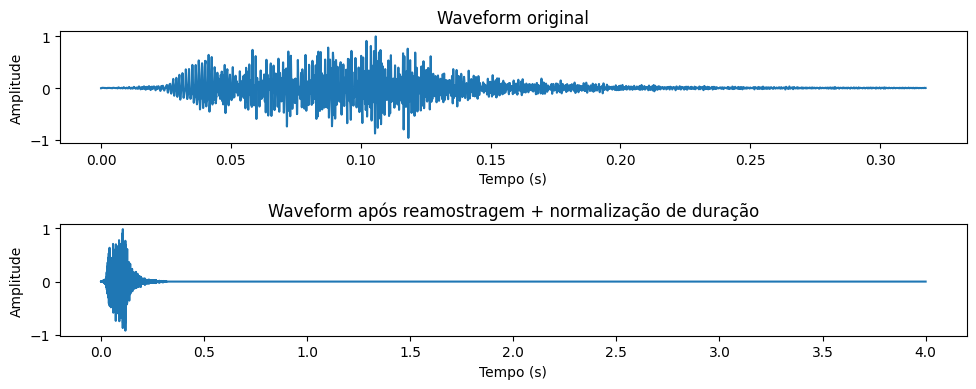

In [9]:
# Criar eixos de tempo para cada waveform
t_orig = np.linspace(0, dur_orig, num=len(y_orig))
t_proc = np.linspace(0, dur_proc, num=len(y_proc))

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.plot(t_orig, y_orig)
plt.title("Waveform original")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t_proc, y_proc)
plt.title("Waveform após reamostragem + normalização de duração")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


##### 3.3. Extração de log-mel-spectrogramas (CNN)

Para a CNN vamos representar cada clipe como uma "imagem" 2D:

- eixo horizontal: tempo;
- eixo vertical: frequência na escala **mel**;
- intensidade: energia (em escala logarítmica).

Esta representação é obtida da seguinte forma:

1. cálculo de um **mel-spectrograma** a partir do waveform;
2. conversão para **escala logarítmica** (dB), resultando num log-mel-spectrograma.

O resultado é uma matriz de dimensão `N_MELS x T`, onde `T` é o número de _frames_
temporais. Mais à frente, ao construir os `Dataset`/`DataLoader`, asseguraremos que
todas as "imagens" têm o mesmo tamanho e que são normalizadas com base nas estatísticas
do conjunto de treino.


In [10]:
def extract_logmel(y, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    """
    Recebe um waveform y e devolve um log-mel-spectrograma 2D (n_mels x time).
    """
    # 1) mel-spectrograma (energia por banda mel ao longo do tempo)
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=n_mels,
        power=2.0      # potência (energia)
    )

    # 2) conversão para dB (escala logarítmica)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    return log_mel_spec.astype(np.float32)


##### 3.4. Extração de vetores de MFCCs agregados (MLP)

Para a MLP vamos usar uma representação mais compacta do som:

1. para cada clipe calculamos **MFCCs** (Mel-Frequency Cepstral Coefficients),
   resultando numa matriz de dimensão `N_MFCC x T`;
2. agregamos estes coeficientes ao longo do tempo, através de:
   - média de cada coeficiente;
   - desvio padrão de cada coeficiente;

obtendo assim um vetor 1D de dimensão `2 * N_MFCC` que resume o conteúdo espectral
do clipe. Este vetor tem dimensão fixa e é adequado para ser usado como entrada
de uma rede totalmente ligada (MLP).


In [11]:
def extract_mfcc_vector(y, sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Recebe um waveform y e devolve um vetor 1D de MFCCs agregados no tempo.
    Concatenação da média e do desvio padrão de cada coeficiente.
    """
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sample_rate,
        n_mfcc=n_mfcc
    )  # shape: (n_mfcc, n_frames)

    # Agregação ao longo do tempo
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)

    # Vetor final: [mean_1, ..., mean_n, std_1, ..., std_n]
    mfcc_features = np.concatenate([mfcc_mean, mfcc_std], axis=0)

    return mfcc_features.astype(np.float32)


##### 3.5. Data augmentation em áudio (apenas para treino)

Para melhorar a capacidade de generalização dos modelos, iremos aplicar *data augmentation*
apenas nos exemplos de treino, antes da extração de _features_. As transformações escolhidas
são simples e conservadoras, de forma a não alterar a classe do som:

- **additive noise**: adicionar um ruído gaussiano fraco ao sinal;
- **time-shift**: deslocar ligeiramente o sinal no tempo;
- **time-stretch leve**: tornar o clipe um pouco mais rápido ou mais lento, voltando
  depois a ajustá-lo à duração alvo.

As funções abaixo não são ainda chamadas nesta fase; serão utilizadas posteriormente,
na definição do `Dataset` de treino.
!!!!! Covém confirmar com o professor se podemos fazer isto sem alterar os fold pre-definidos

In [12]:
import random

def add_noise(y, noise_factor=0.02):
    """
    Adiciona ruído gaussiano fraco ao sinal.
    noise_factor controla a intensidade relativa do ruído.
    """
    noise = np.random.randn(len(y))
    augmented = y + noise_factor * noise
    return augmented.astype(np.float32)

def time_shift(y, max_shift_fraction=0.2):
    """
    Desloca o sinal no tempo.
    max_shift_fraction = fracção máxima do comprimento a deslocar.
    """
    max_shift = int(len(y) * max_shift_fraction)
    shift = random.randint(-max_shift, max_shift)
    shifted = np.roll(y, shift)
    return shifted.astype(np.float32)

def time_stretch(y, rate_low=0.9, rate_high=1.1):
    """
    Time-stretch leve: torna o áudio um pouco mais rápido ou lento.
    No fim, volta a ajustar para o tamanho original com padding/corte.
    """
    rate = np.random.uniform(rate_low, rate_high)
    stretched = librosa.effects.time_stretch(y, rate)

    # voltar ao comprimento original
    if len(stretched) > len(y):
        stretched = stretched[:len(y)]
    elif len(stretched) < len(y):
        pad_width = len(y) - len(stretched)
        stretched = np.pad(stretched, (0, pad_width))

    return stretched.astype(np.float32)

def augment_audio(y, apply_noise=True, apply_shift=True, apply_stretch=False):
    """
    Aplica, de forma aleatória, algumas transformações de data augmentation.
    Esta função será usada apenas em exemplos de treino.
    """
    y_aug = y.copy()

    if apply_noise and random.random() < 0.5:
        y_aug = add_noise(y_aug)

    if apply_shift and random.random() < 0.5:
        y_aug = time_shift(y_aug)

    if apply_stretch and random.random() < 0.3:
        y_aug = time_stretch(y_aug)

    return y_aug


##### 3.6. Verificação inicial do pipeline de pré-processamento

Antes de avançar para a definição dos modelos, verificamos se as funções de
carregamento e extração de _features_ se comportam como esperado num exemplo
simples do UrbanSound8K.


Exemplo de ficheiro de áudio: ./UrbanSound8K/audio\fold5\100032-3-0-0.wav
Waveform shape: (88200,)
Log-mel shape (n_mels x time): (64, 173)
MFCC vector shape: (40,)


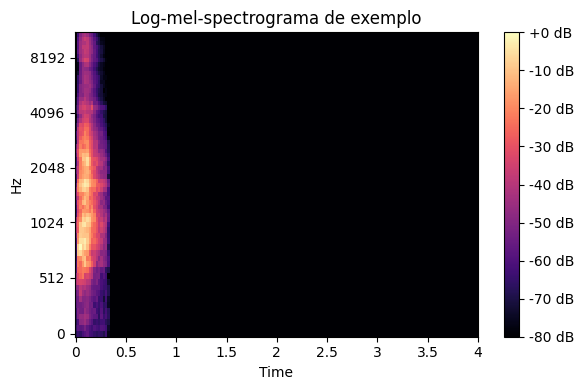

In [13]:
# Escolher um exemplo do DataFrame
example_row = df.iloc[0]
example_path = get_audio_path(example_row)
print("Exemplo de ficheiro de áudio:", example_path)

# Waveform com duração fixa
y = load_fixed_audio(example_path)
print("Waveform shape:", y.shape)

# Log-mel-spectrograma (para a CNN)
log_mel = extract_logmel(y)
print("Log-mel shape (n_mels x time):", log_mel.shape)

# Vetor de MFCCs agregados (para a MLP)
mfcc_vec = extract_mfcc_vector(y)
print("MFCC vector shape:", mfcc_vec.shape)

# Ouvir o áudio e visualizar o espectrograma
display(ipd.Audio(y, rate=SAMPLE_RATE))

plt.figure(figsize=(6, 4))
librosa.display.specshow(log_mel, sr=SAMPLE_RATE, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-mel-spectrograma de exemplo")
plt.tight_layout()
plt.show()


Além do log-mel-spectrograma, que será usado como entrada da CNN, podemos inspecionar
o vetor de MFCCs agregados que servirá de entrada para a MLP. 


In [14]:
# Visualizar o vetor de MFCCs agregados (input da MLP)
print("Valores do vetor MFCC:", list[mfcc_vec])

Valores do vetor MFCC: list[array([-5.9222247e+02,  5.5740514e+00, -1.0476468e+01, -5.2723722e+00,
       -1.0548183e+00, -2.3633459e+00, -3.0192697e-01,  1.0254046e+00,
        1.1024994e+00,  6.6860217e-01, -5.5734491e-01, -2.6747948e-01,
       -1.0505089e+00,  4.8320770e-01, -2.3346704e-01, -4.5534027e-01,
       -1.2913095e+00, -5.2421447e-02, -1.1618857e-01,  5.4438192e-01,
        1.1926790e+02,  1.9307783e+01,  3.4108513e+01,  1.7263634e+01,
        4.7783957e+00,  9.7486267e+00,  1.8795525e+00,  3.8568587e+00,
        3.8075886e+00,  2.8143618e+00,  2.6950965e+00,  1.4781656e+00,
        3.9989703e+00,  1.8091406e+00,  1.5632513e+00,  1.9547031e+00,
        4.3257847e+00,  1.4251807e+00,  1.4478124e+00,  1.9533737e+00],
      dtype=float32)]


#### 4. Model architecture definition

Nesta secção definimos as arquiteturas dos dois classificadores base utilizados
no trabalho:

- uma **MLP** (rede totalmente ligada) aplicada a vetores de MFCCs agregados;
- uma **CNN 2D** aplicada a log-mel-spectrogramas.

O objetivo é manter arquiteturas suficientemente expressivas para captarem
padrões relevantes nos sons urbanos, mas com dimensão controlada para reduzir
overfitting num dataset relativamente pequeno como o UrbanSound8K.


##### 4.1. MLP architecture (MFCC features)

Para o primeiro classificador utilizamos uma **rede totalmente ligada (MLP)**,
treinada sobre vetores de MFCCs agregados no tempo (secção 3.4). Recordando:

- cada clipe é representado por um vetor de dimensão `2 * N_MFCC`, contendo
  as médias e os desvios padrão dos coeficientes MFCC ao longo do tempo;
- esta representação é compacta e perde informação temporal fina, mas reduz
  a dimensionalidade e o risco de overfitting, sendo adequada para uma MLP.

Do ponto de vista de capacidade do modelo, optamos por uma arquitetura simples
mas expressiva:

- camada de entrada com dimensão `input_dim = 2 * N_MFCC`;
- duas camadas escondidas densas com funções de ativação ReLU;
- _dropout_ entre camadas escondidas para reduzir overfitting;
- camada de saída com 10 neurónios (uma por classe), compatível com
  `CrossEntropyLoss`.

Esta arquitetura procura um equilíbrio entre:
- número de parâmetros (capacidade para modelar fronteiras não lineares
  entre classes de som);
- e regularização (dropout + L2 na fase de treino), de forma a generalizar
  bem para os folds de teste.


In [15]:
NUM_CLASSES = df["classID"].nunique()  # deve ser 10

# dimensão de entrada = 2 * N_MFCC (mean + std)
MLP_INPUT_DIM = 2 * N_MFCC

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=MLP_INPUT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(128, num_classes)
            # CrossEntropyLoss em PyTorch já aplica softmax internamente aos logits
        )

    def forward(self, x):
        # x: (batch_size, input_dim)
        return self.net(x)


##### 4.1.1. Visão global da arquitetura MLP

A Figura abaixo resume a arquitetura da MLP aplicada aos vetores de MFCCs
agregados (mean + std):

```text
           Vetor MFCC (2 * N_MFCC)
                dimensão = 40  (exemplo)

                         │
                         ▼
                [ Fully Connected ]
                 Linear(40 → 256)
                       + ReLU
                     Dropout 0.5
                         │
                         ▼
                [ Fully Connected ]
                 Linear(256 → 128)
                       + ReLU
                     Dropout 0.5
                         │
                         ▼
                [  Camada de saída  ]
                 Linear(128 → 10)
                  (logits por classe)
                         │
                         ▼
                Softmax (implícito na CrossEntropyLoss)


In [37]:
# Sanity check da arquitetura MLP
mlp = MLPClassifier()
print(mlp)

MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


##### 4.1.2. Teste

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp = MLPClassifier()
dummy_input = torch.randn(4, MLP_INPUT_DIM)  # batch de 4 exemplos

with torch.no_grad():
    out = mlp(dummy_input)

print("MLP output shape:", out.shape)   # esperado: (4, NUM_CLASSES)
print("Número de parâmetros treináveis na MLP:", count_parameters(mlp))


MLP output shape: torch.Size([4, 10])
Número de parâmetros treináveis na MLP: 44682


O teste rápido com um _dummy batch_ confirma que a MLP recebe vetores de
dimensão `2 * N_MFCC` e produz logits de dimensão 10 (uma entrada por classe):
o `forward` com um _batch_ de 4 exemplos resulta num `output` com shape
`torch.Size([4, 10])`.

O número total de parâmetros treináveis é de **44 682**, o que corresponde a
uma rede relativamente compacta, mas ainda com capacidade suficiente para
modelar fronteiras não lineares entre as classes de som. Esta ordem de grandeza
é adequada à dimensão do UrbanSound8K: o modelo não é tão pequeno ao ponto de
sofrer de underfitting severo, nem tão grande que torne o overfitting inevitável,
especialmente quando combinado com dropout e regularização L2 na fase de treino.



##### 4.2. CNN architecture (log-mel spectrograms)

O segundo classificador é uma **CNN 2D** que recebe, como entrada, os
log-mel-spectrogramas definidos na secção 3.3. Cada clipe é convertido numa
“imagem” 2D:

- eixo horizontal: tempo (frames);
- eixo vertical: bandas de frequência na escala mel;
- intensidade: energia em dB.

As CNNs são particularmente adequadas para este tipo de dados, pois aprendem
filtros locais que captam padrões tempo–frequência característicos de cada
classe de som (ataques rápidos, harmónicos, texturas de ruído, etc.).

Para controlar a complexidade do modelo, utilizamos uma arquitetura do tipo
“VGG pequena”, com blocos convolucionais seguidos de _max-pooling_:

- 2 blocos `Conv → ReLU → Conv → ReLU → MaxPool`;
- opcionalmente um terceiro bloco mais pequeno;??
- camadas densas finais com Dropout para classificação em 10 classes.

Para evitar depender de cálculos manuais do tamanho espacial após as várias
camadas, usamos uma camada de `AdaptiveAvgPool2d`, que reduz o mapa de
características para uma grelha fixa antes da parte totalmente ligada.


In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # reduz H e W a metade
        )

    def forward(self, x):
        return self.block(x)


class CNNSpectrogramClassifier(nn.Module):
    def __init__(self, n_mels=N_MELS, num_classes=NUM_CLASSES):
        super().__init__()
        # Espera input (batch_size, 1, n_mels, T)
        self.features = nn.Sequential(
            ConvBlock(1, 32),   # (1 → 32)
            ConvBlock(32, 64),  # (32 → 64)
            ConvBlock(64, 128)  # opcionalmente poderíamos parar em 64
        )

        # Reduz para um tamanho espacial fixo (por exemplo 4x4)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Camada totalmente ligada
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # 128 * 4 * 4 features
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


##### 4.2.1. Visão global da arquitetura CNN

A Figura seguinte mostra, de forma simplificada, a arquitetura da CNN aplicada
a log-mel-spectrogramas com `N_MELS = 64` bandas e `T` frames temporais:

```text
      Log-mel-spectrograma
   tensor (1, 64, T)  →  (canal, freq, tempo)

                         │
                         ▼
                Bloco conv 1
        Conv2d(1 → 32, 3×3, padding=1)
                 + BatchNorm + ReLU
        Conv2d(32 → 32, 3×3, padding=1)
                 + BatchNorm + ReLU
              MaxPool2d(2×2)   ↓  (reduce H,W by 2)

                         │
                         ▼
                Bloco conv 2
        Conv2d(32 → 64, 3×3, padding=1)
                 + BatchNorm + ReLU
        Conv2d(64 → 64, 3×3, padding=1)
                 + BatchNorm + ReLU
              MaxPool2d(2×2)

                         │
                         ▼
                Bloco conv 3
        Conv2d(64 → 128, 3×3, padding=1)
                 + BatchNorm + ReLU
              MaxPool2d(2×2)

                         │
                         ▼
         AdaptiveAvgPool2d(4×4)
      (reduz o mapa de ativação para 128×4×4)

                         │
                         ▼
                  Flatten
          vetor de dimensão 128 * 4 * 4

                         │
                         ▼
             [ Fully Connected ]
              Linear(128*4*4 → 256)
                     + ReLU
                   Dropout 0.5

                         │
                         ▼
             [ Camada de saída ]
                Linear(256 → 10)
                 (logits por classe)

In [36]:
# Sanity check da arquitetura CNN
cnn = CNNSpectrogramClassifier()
print(cnn)

CNNSpectrogramClassifier(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

##### 4.2.2. Teste

In [18]:
# Gerar um log-mel a partir do exemplo que já tínhamos
example_row = df.iloc[0]
example_path = get_audio_path(example_row)
y = load_fixed_audio(example_path)
log_mel = extract_logmel(y)  # shape: (N_MELS, T)

# Converter para tensor 4D (batch, channel, H, W)
log_mel_tensor = torch.from_numpy(log_mel).unsqueeze(0).unsqueeze(0)  # (1, 1, n_mels, T)

cnn = CNNSpectrogramClassifier()

with torch.no_grad():
    out = cnn(log_mel_tensor)

print("Input log-mel shape (tensor):", log_mel_tensor.shape)
print("CNN output shape:", out.shape)
print("Número de parâmetros treináveis na CNN:", count_parameters(cnn))


Input log-mel shape (tensor): torch.Size([1, 1, 64, 173])
CNN output shape: torch.Size([1, 10])
Número de parâmetros treináveis na CNN: 814442


Para a CNN, o sanity check foi realizado com um log-mel-spectrograma real
extraído do UrbanSound8K. O tensor de entrada apresenta shape
`torch.Size([1, 1, 64, 173])`, correspondendo a:

- _batch size_ = 1;
- 1 canal (espectrograma mono);
- 64 bandas mel;
- 173 _frames_ temporais.

A rede produz logits de dimensão 10, com `output` de shape
`torch.Size([1, 10])`, como esperado para um problema de classificação com
10 classes.

O número total de parâmetros treináveis da CNN é de **814 442**, cerca de uma
ordem de grandeza acima da MLP. Isto reflete a maior capacidade da CNN para
explorar padrões tempo–frequência complexos nos log-mel-spectrogramas. Ainda
assim, trata-se de uma arquitetura moderada, e o risco de overfitting será mitigado através de técnicas como
_data augmentation_, dropout e regularização L2, bem como pela avaliação
em 10-fold cross-validation.


#### 5. Training strategies

Depois de definir as representações de áudio (MFCCs e log-mel-spectrogramas) e
as arquiteturas dos modelos (MLP e CNN), nesta secção especificamos a estratégia
de treino adotada. O objetivo é:

- respeitar rigorosamente a divisão em 10 folds do UrbanSound8K;
- detetar, através de um primeiro treino "baseline", problemas típicos como
  underfitting ou overfitting;
- ajustar a estratégia (regularização, _data augmentation_, hiperparâmetros)
  e repetir o treino com configurações melhoradas.

Para cada modelo (MLP e CNN), vamos assim realizar pelo menos dois ciclos de
experiências:

1. **Treino 1 – baseline:** configuração simples, sem _data augmentation_
   e com regularização mínima, para observar o comportamento inicial da rede.
2. **Treino 2 – ajustado:** introdução de técnicas adicionais
   (augmentation em áudio, weight decay, ajustes de learning rate, etc.) com o
   objetivo de melhorar a capacidade de generalização.

Em todas as experiências utilizamos 10-fold cross-validation, garantindo que em
cada iteração:

- 1 fold é usado exclusivamente para **teste**;
- 1 fold é usado para **validação** (early stopping, ajuste de hiperparâmetros);
- os 8 folds restantes são utilizados para **treino**.


##### 5.1. Dataset e DataLoaders

Para facilitar o treino e a validação, encapsulamos o _pipeline_ de
pré-processamento (carregamento do áudio, eventual _data augmentation_ e extração
de _features_) numa classe `Dataset` em PyTorch. Esta classe recebe:

- o `DataFrame` com a metadata (`df`);
- a lista de folds a utilizar (`train`, `val` ou `test`);
- o tipo de modelo (`"mlp"` ou `"cnn"`);
- um indicador se estamos em modo `"train"`, `"val"` ou `"test"`.

No caso da MLP, opcionalmente aplicamos uma normalização global (`StandardScaler`)
aos vetores de MFCCs, ajustada apenas nos folds de treino.


In [19]:
class UrbanSoundDataset(Dataset):
    def __init__(
        self,
        df,
        folds,
        mode,
        model_type="mlp",
        scaler=None,
        apply_augmentation=False,
    ):
        """
        df: DataFrame completo do UrbanSound8K.
        folds: lista de folds a incluir neste dataset (ex.: [1,2,3,4,5,6,7,8]).
        mode: "train", "val" ou "test".
        model_type: "mlp" (MFCCs) ou "cnn" (log-mel).
        scaler: StandardScaler já ajustado (apenas para MLP).
        apply_augmentation: se True, usa augment_audio() nos exemplos de treino.
        """
        self.df = df[df["fold"].isin(folds)].reset_index(drop=True)
        self.mode = mode
        self.model_type = model_type
        self.scaler = scaler
        self.apply_augmentation = apply_augmentation and (mode == "train")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = get_audio_path(row)

        # 1) carregar waveform com duração fixa
        y = load_fixed_audio(path)

        # 2) data augmentation (apenas em treino)
        if self.apply_augmentation:
            y = augment_audio(y)

        # 3) extrair features
        if self.model_type == "cnn":
            feat = extract_logmel(y)           # (n_mels, T)
            # normalização por-clipe (zero mean / unit std) – simples e estável
            feat = (feat - feat.mean()) / (feat.std() + 1e-8)
            # para PyTorch: (channels=1, H, W)
            feat = torch.from_numpy(feat).unsqueeze(0)  # (1, n_mels, T)

        elif self.model_type == "mlp":
            feat = extract_mfcc_vector(y)      # (2 * N_MFCC,)
            feat = feat.reshape(1, -1)         # para usar scaler
            if self.scaler is not None:
                feat = self.scaler.transform(feat)
            feat = torch.from_numpy(feat.astype(np.float32)).squeeze(0)

        else:
            raise ValueError("model_type deve ser 'mlp' ou 'cnn'.")

        label = int(row["classID"])
        label = torch.tensor(label, dtype=torch.long)

        return feat, label


In [33]:
def create_dataloaders_for_fold(
    df,
    test_fold,
    val_fold,
    model_type,
    batch_size=64,
    apply_augmentation=False,
):
    """
    Cria DataLoaders de train/val/test para um dado par (test_fold, val_fold).
    Para a MLP, ajusta um StandardScaler apenas nos folds de treino.
    """
    all_folds = sorted(df["fold"].unique())
    train_folds = [f for f in all_folds if f not in [test_fold, val_fold]]

    # === MLP: ajustar scaler nos vetores de MFCCs dos folds de treino ===
    scaler = None
    if model_type == "mlp":
        # recolher MFCCs de treino só para calcular mean/std global
        mfcc_list = []
        for idx, row in df[df["fold"].isin(train_folds)].iterrows():
            y = load_fixed_audio(get_audio_path(row))
            mfcc_vec = extract_mfcc_vector(y)
            mfcc_list.append(mfcc_vec)
        mfcc_array = np.stack(mfcc_list, axis=0)
        scaler = StandardScaler().fit(mfcc_array)

    train_dataset = UrbanSoundDataset(
        df, folds=train_folds, mode="train",
        model_type=model_type, scaler=scaler,
        apply_augmentation=apply_augmentation
    )

    val_dataset = UrbanSoundDataset(
        df, folds=[val_fold], mode="val",
        model_type=model_type, scaler=scaler,
        apply_augmentation=False
    )

    test_dataset = UrbanSoundDataset(
        df, folds=[test_fold], mode="test",
        model_type=model_type, scaler=scaler,
        apply_augmentation=False
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


##### 5.2. Funções de treino e avaliação

Definimos em seguida funções genéricas para:

- treinar um modelo durante um _epoch_ (`train_one_epoch`);
- avaliar o modelo num `DataLoader` (`evaluate_model`);
- executar o ciclo de _early stopping_ com base no fold de validação.

A _loss_ utilizada é sempre `CrossEntropyLoss`, adequada a problemas de
classificação multiclasse com 10 classes.


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, dataloader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc


Using device: cpu


In [31]:
def train_on_fold(
    model_class,
    model_type,
    df,
    test_fold,
    val_fold,
    max_epochs=50,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    apply_augmentation=False,
    patience=7,
):
    """
    Treina um modelo (MLP ou CNN) num par (train_folds, val_fold) e avalia no test_fold.

    Devolve:
    - best_val_loss
    - (test_loss, test_acc)
    - history: dict com listas de train/val loss/acc
    - y_true_test: rótulos verdadeiros do fold de teste (numpy array)
    - y_pred_test: previsões do modelo no fold de teste (numpy array)
    """

    # criar dataloaders (igual ao que tinhas antes)
    train_loader, val_loader, test_loader = create_dataloaders_for_fold(
        df,
        test_fold=test_fold,
        val_fold=val_fold,
        model_type=model_type,
        batch_size=batch_size,
        apply_augmentation=apply_augmentation,
    )

    # instanciar modelo e otimizador
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate_model(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch:02d}] "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

        # early stopping com base na val_loss
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping após {epoch} epochs (sem melhoria em {patience} epochs).")
            break

    # restaurar melhor modelo
    if best_state is not None:
        model.load_state_dict(best_state)

    # avaliar no test fold guardando previsões e rótulos
    model.eval()
    all_y_true = []
    all_y_pred = []
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)

            all_y_true.extend(targets.cpu().numpy())
            all_y_pred.extend(preds.cpu().numpy())
            total += targets.size(0)

    test_loss = running_loss / total
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    test_acc = (all_y_true == all_y_pred).mean()

    print(f"[TEST fold={test_fold}] loss={test_loss:.4f} acc={test_acc:.4f}")

    return best_val_loss, (test_loss, test_acc), history, all_y_true, all_y_pred


In [30]:
def hyperparam_search_single_fold(
    model_class,
    model_type,
    df,
    test_fold=8,
    val_fold=9,
    learning_rates=(1e-3, 3e-4),
    weight_decays=(0.0, 1e-4),
    batch_sizes=(32, 64),
    max_epochs=30,
    patience=7,
    apply_augmentation=False,
):
    """
    Pequena grid search num único par (test_fold, val_fold).
    Devolve um DataFrame com resultados por combinação de hiperparâmetros.
    """

    configs = list(itertools.product(learning_rates, weight_decays, batch_sizes))

    results = []

    for lr, wd, bs in configs:
        print("\n" + "#"*70)
        print(f"Experiência: lr={lr}, weight_decay={wd}, batch_size={bs}")
        print(f"(test_fold={test_fold}, val_fold={val_fold})")
        print("#"*70)

        best_val_loss, (test_loss, test_acc), history, y_true, y_pred = train_on_fold(
            model_class=model_class,
            model_type=model_type,
            df=df,
            test_fold=test_fold,
            val_fold=val_fold,
            max_epochs=max_epochs,
            batch_size=bs,
            lr=lr,
            weight_decay=wd,
            apply_augmentation=apply_augmentation,
            patience=patience,
        )

        # métricas a partir do history
        best_val_acc = max(history["val_acc"])
        final_train_loss = history["train_loss"][-1]
        final_train_acc = history["train_acc"][-1]
        n_epochs = len(history["train_loss"])

        results.append({
            "lr": lr,
            "weight_decay": wd,
            "batch_size": bs,
            "epochs": n_epochs,
            "best_val_loss": best_val_loss,
            "best_val_acc": best_val_acc,
            "final_train_loss": final_train_loss,
            "final_train_acc": final_train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        })

    results_df = pd.DataFrame(results)

    # ordenar por melhor val_loss (podes mudar para best_val_acc se preferires)
    results_df = results_df.sort_values(by="best_val_loss").reset_index(drop=True)

    print("\n=== Resumo da mini-grid search ===")
    display(results_df)

    return results_df


##### 5.4. Protocolo de 10-fold cross-validation

Seguimos um protocolo estrito de 10-fold cross-validation. Em cada iteração `k`:

- o fold `k` é usado como **teste**;
- o fold seguinte `(k % 10) + 1` é usado como **validação**;
- os 8 folds restantes são usados para **treino**.

Este esquema garante que:

- cada fold desempenha o papel de teste exatamente uma vez;
- nunca há mistura de exemplos entre treino, validação e teste na mesma
  iteração (em particular, não há sobreposição entre test e train);
- os folds pré-definidos do UrbanSound8K são integralmente respeitados.

In [29]:
def run_cross_validation(
    model_class,
    model_type,
    df,
    max_epochs=50,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    apply_augmentation=False,
    patience=7,
):
    """
    Faz 10-fold cross-validation.

    Devolve um dicionário com:
    - test_losses: lista de test_loss por fold
    - test_accs: lista de test_acc por fold
    - histories: lista de histories (um por fold, com train/val loss/acc)
    - y_true_all: rótulos verdadeiros concatenados de todos os folds de teste
    - y_pred_all: previsões concatenadas de todos os folds de teste
    - y_true_folds: lista de arrays y_true por fold
    - y_pred_folds: lista de arrays y_pred por fold
    """

    test_losses = []
    test_accs = []
    histories = []

    # para global
    all_test_true = []
    all_test_pred = []

    # para ter por fold
    y_true_folds = []
    y_pred_folds = []

    folds = sorted(df["fold"].unique())

    for k in folds:
        test_fold = k
        val_fold = (k % 10) + 1  # fold seguinte: 1->2, 2->3, ..., 10->1

        print("\n" + "="*60)
        print(f"Fold iteração: test_fold={test_fold}, val_fold={val_fold}")
        print("="*60)

        best_val_loss, (test_loss, test_acc), history, y_true, y_pred = train_on_fold(
            model_class=model_class,
            model_type=model_type,
            df=df,
            test_fold=test_fold,
            val_fold=val_fold,
            max_epochs=max_epochs,
            batch_size=batch_size,
            lr=lr,
            weight_decay=weight_decay,
            apply_augmentation=apply_augmentation,
            patience=patience,
        )

        test_losses.append(test_loss)
        test_accs.append(test_acc)
        histories.append(history)

        # global
        all_test_true.append(y_true)
        all_test_pred.append(y_pred)

        # por fold
        y_true_folds.append(y_true)
        y_pred_folds.append(y_pred)

    all_test_true = np.concatenate(all_test_true)
    all_test_pred = np.concatenate(all_test_pred)

    print("\n=== RESULTADOS FINAIS (10-fold CV) ===")
    print(f"Test loss média: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
    print(f"Test accuracy média: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")

    return {
        "test_losses": test_losses,
        "test_accs": test_accs,
        "histories": histories,
        "y_true_all": all_test_true,
        "y_pred_all": all_test_pred,
        "y_true_folds": y_true_folds,
        "y_pred_folds": y_pred_folds,
    }


##### 5.5.1. Experimento 1 – MLP baseline (sem data augmentation)

Como primeiro passo, treinamos a MLP numa configuração baseline:

- sem _data augmentation_;
- sem regularização L2 (`weight_decay = 0`);
- `batch_size = 64`;
- `learning rate = 1e-3` (Adam);
- `patience = 7` epochs para _early stopping_.

Este experimento serve para identificar padrões de under/overfitting e obter uma
linha de base de desempenho para o classificador sobre MFCCs.


In [24]:
results_mlp_baseline = run_cross_validation(
    model_class=MLPClassifier,
    model_type="mlp",
    df=df,
    max_epochs=40,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    apply_augmentation=False,
    patience=7,
)



Fold iteração: test_fold=1, val_fold=2
[Epoch 01] train_loss=1.6386 acc=0.4164 | val_loss=1.2302 acc=0.5214
[Epoch 02] train_loss=1.1627 acc=0.5818 | val_loss=1.1479 acc=0.5417
[Epoch 03] train_loss=1.0197 acc=0.6395 | val_loss=1.1076 acc=0.5293
[Epoch 04] train_loss=0.9304 acc=0.6784 | val_loss=1.0823 acc=0.5721
[Epoch 05] train_loss=0.8752 acc=0.6953 | val_loss=1.0847 acc=0.5698
[Epoch 06] train_loss=0.8271 acc=0.7157 | val_loss=1.0183 acc=0.5935
[Epoch 07] train_loss=0.7751 acc=0.7366 | val_loss=1.0354 acc=0.6002
[Epoch 08] train_loss=0.7452 acc=0.7459 | val_loss=1.0073 acc=0.6137
[Epoch 09] train_loss=0.7206 acc=0.7540 | val_loss=1.0084 acc=0.6104
[Epoch 10] train_loss=0.6916 acc=0.7650 | val_loss=0.9915 acc=0.6014
[Epoch 11] train_loss=0.6758 acc=0.7754 | val_loss=1.0085 acc=0.6014
[Epoch 12] train_loss=0.6445 acc=0.7835 | val_loss=0.9802 acc=0.6047
[Epoch 13] train_loss=0.6250 acc=0.7848 | val_loss=0.9966 acc=0.6126
[Epoch 14] train_loss=0.6072 acc=0.7986 | val_loss=1.0466 acc=0

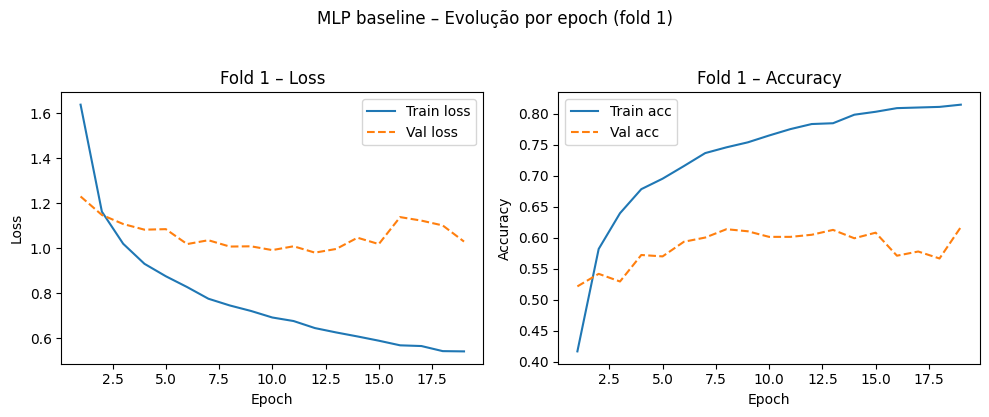

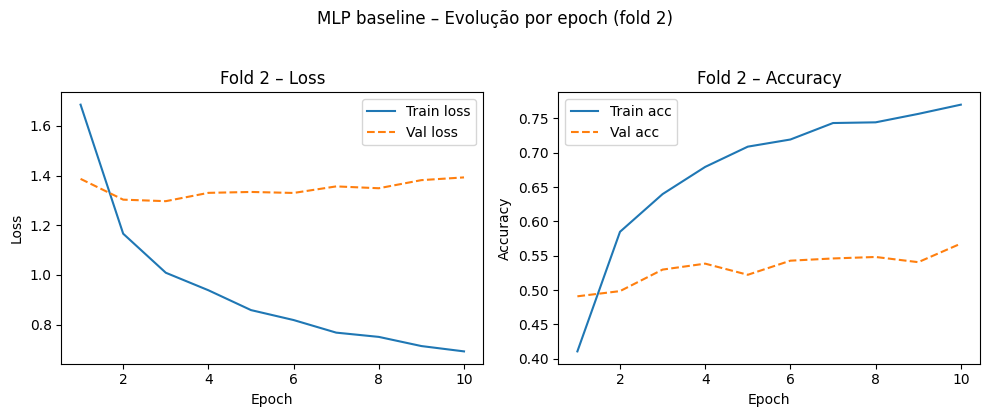

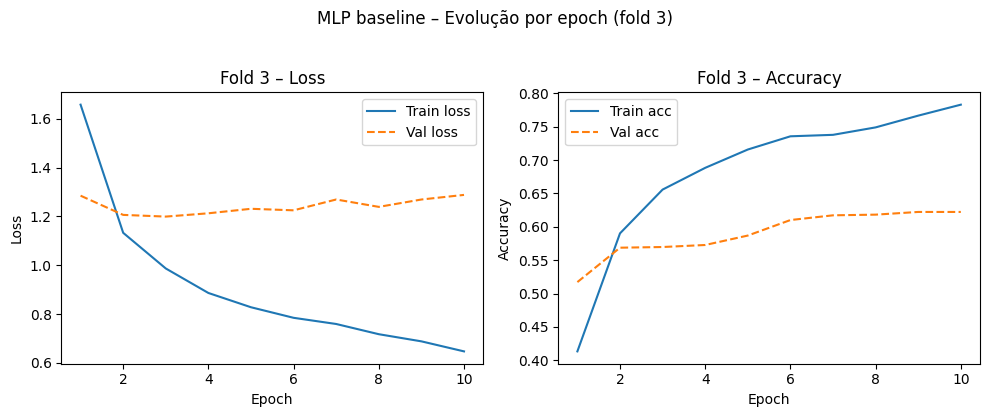

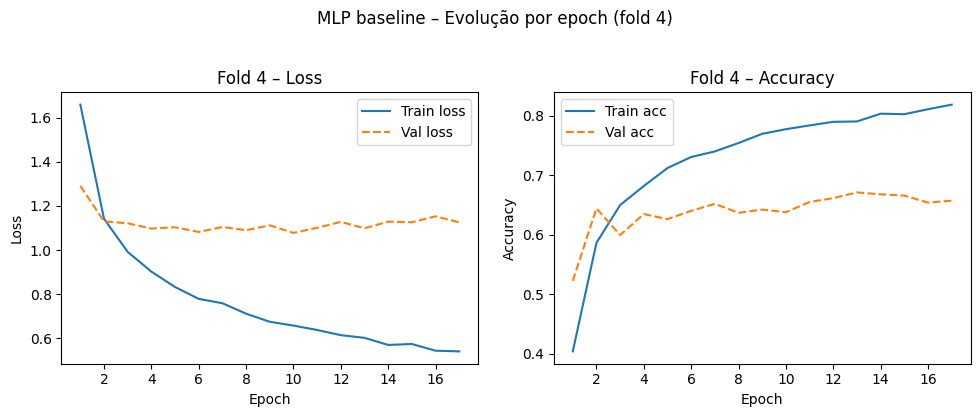

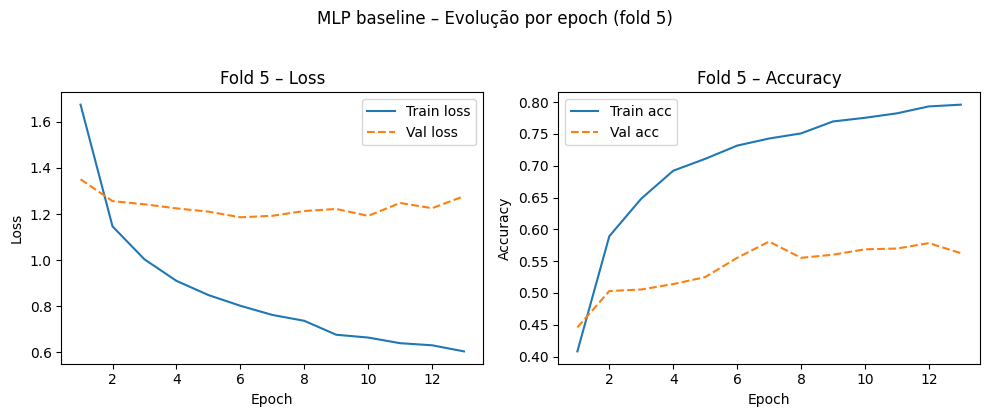

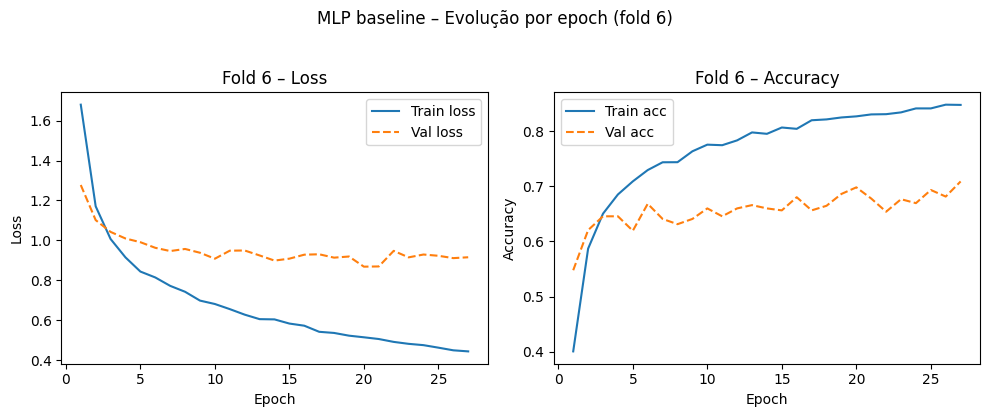

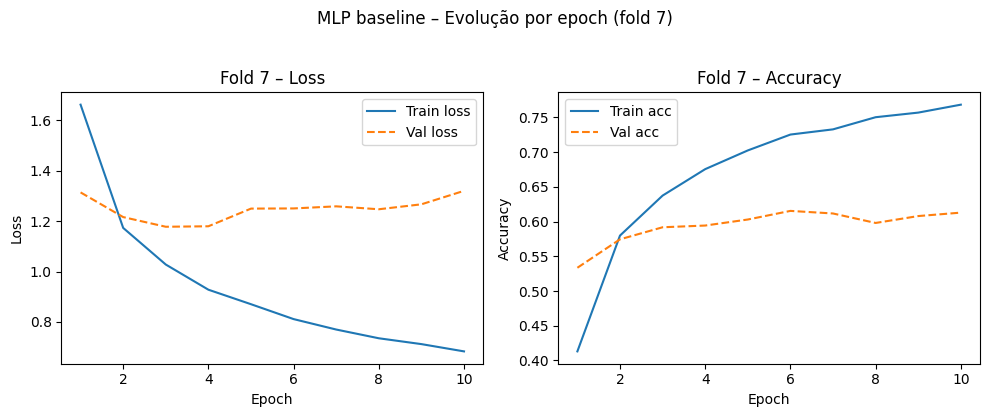

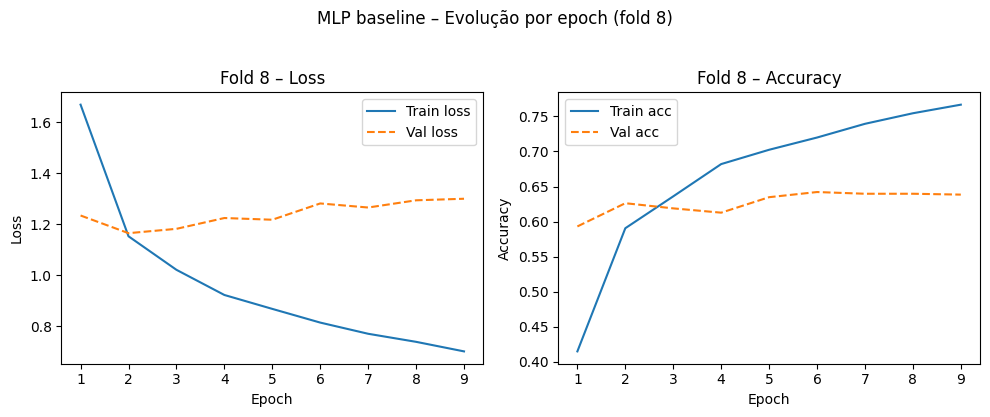

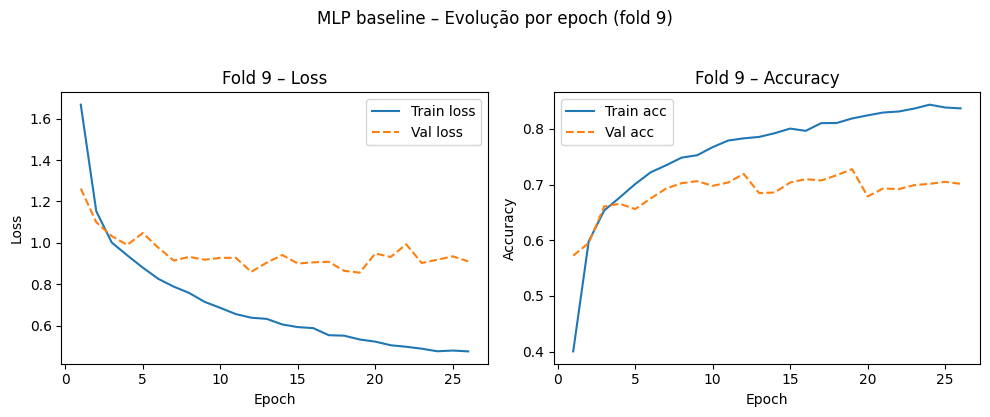

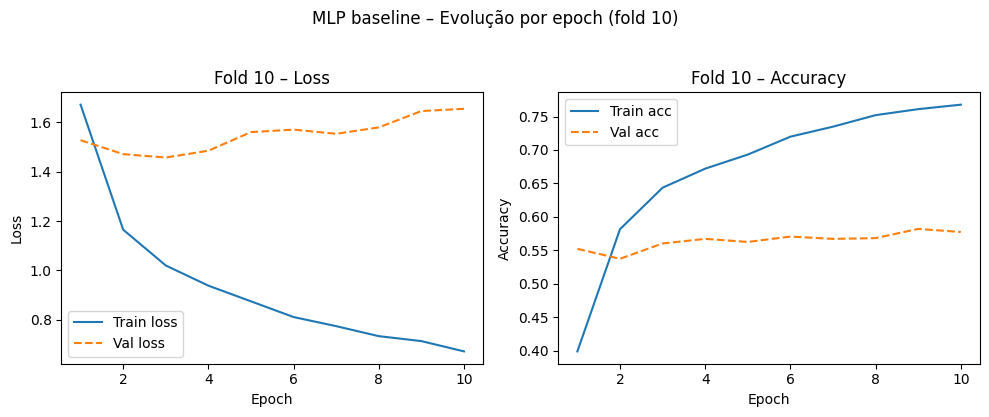

In [38]:
histories = results_mlp_baseline["histories"]

for i, hist in enumerate(histories, start=1):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))

    # --- Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["train_loss"], label="Train loss")
    plt.plot(epochs, hist["val_loss"], linestyle="--", label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {i} – Loss")
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["train_acc"], label="Train acc")
    plt.plot(epochs, hist["val_acc"], linestyle="--", label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Fold {i} – Accuracy")
    plt.legend()

    plt.suptitle(f"MLP baseline – Evolução por epoch (fold {i})", y=1.03, fontsize=12)
    plt.tight_layout()
    plt.show()



A MLP consegue atingir valores de accuracy elevados no conjunto de treino (≈80%), o que mostra que a arquitetura tem capacidade suficiente para modelar as relações entre os MFCCs e as classes.

A MLP baseline mostra um comportamento típico de overfitting: após poucas épocas a performance no treino continua a melhorar, enquanto a performance de validação tende a estabilizar ou mesmo degradar ligeiramente.

Observa-se ainda uma variância significativa entre folds, em linha com a distribuição desigual de algumas classes entre os folds do UrbanSound8K.

##### 5.5.2. Experimento 2 – Grid search num fold fixo
Uma vez que o custo computacional de fazer uma grid seacrh dentro do 10-fold cross validation, decididmos analisar os folds e ecolher um com melhor representatividade. Nesse fold, aplicamos uma grid search para hyper parameter tunning. Onde comparamos a diferentes combinações de parâmetros:


In [34]:
results_mlp_tuning = hyperparam_search_single_fold(
    model_class=MLPClassifier,
    model_type="mlp",
    df=df,
    test_fold=8,
    val_fold=9,
    learning_rates=(1e-3, 3e-4),   # pequeno conjunto de LRs
    weight_decays=(0.0, 1e-4),     # sem L2 vs com L2
    batch_sizes=(32, 64),         # dois tamanhos de batch
    max_epochs=25,                # podes baixar para acelerar
    patience=7,
    apply_augmentation=False,     # normalmente no tuning da MLP baseline
)



######################################################################
Experiência: lr=0.001, weight_decay=0.0, batch_size=32
(test_fold=8, val_fold=9)
######################################################################
[Epoch 01] train_loss=1.5345 acc=0.4561 | val_loss=1.1643 acc=0.6042
[Epoch 02] train_loss=1.0673 acc=0.6249 | val_loss=1.1995 acc=0.5882
[Epoch 03] train_loss=0.9250 acc=0.6797 | val_loss=1.2113 acc=0.6225
[Epoch 04] train_loss=0.8376 acc=0.7131 | val_loss=1.2596 acc=0.6311
[Epoch 05] train_loss=0.7950 acc=0.7291 | val_loss=1.2702 acc=0.6262
[Epoch 06] train_loss=0.7272 acc=0.7513 | val_loss=1.2428 acc=0.6275
[Epoch 07] train_loss=0.6969 acc=0.7662 | val_loss=1.2817 acc=0.6409
[Epoch 08] train_loss=0.6477 acc=0.7781 | val_loss=1.3321 acc=0.6385
Early stopping após 8 epochs (sem melhoria em 7 epochs).
[TEST fold=8] loss=1.4232 acc=0.6712

######################################################################
Experiência: lr=0.001, weight_decay=0.0, batch_size=64
(te

,lr,weight_decay,batch_size,epochs,best_val_loss,best_val_acc,final_train_loss,final_train_acc,test_loss,test_acc
0,0.0010,0.0001,32,9,1.120540,0.653186,0.635024,0.787201,1.409586,0.641439
1,0.0010,0.0001,64,10,1.149984,0.655637,0.673066,0.775949,1.304497,0.622829
2,0.0003,0.0001,32,14,1.150263,0.638480,0.764098,0.743741,1.237345,0.653846
3,0.0003,0.0000,64,14,1.152024,0.633578,0.825726,0.714346,1.230220,0.607940
4,0.0010,0.0000,32,8,1.164330,0.640931,0.647723,0.778059,1.423203,0.671216
5,0.0003,0.0001,64,12,1.175120,0.637255,0.887890,0.690155,1.179337,0.617866
6,0.0010,0.0000,64,10,1.177012,0.647059,0.677398,0.774824,1.269204,0.616625
7,0.0003,0.0000,32,10,1.181843,0.649510,0.847342,0.711674,1.221717,0.609181


Realizámos uma pequena pesquisa de hiperparâmetros num único par de folds (train: folds ≠ {8,9}, validação: fold 9, teste: fold 8), variando learning_rate ∈ {1e-3, 3e-4}, weight_decay ∈ {0, 1e-4} e batch_size ∈ {32, 64}.
Os resultados mostram que:

batch_size = 32 apresenta, de forma robusta, melhor capacidade de generalização no fold de teste do que batch_size = 64;

learning_rate = 1e-3 converge mais rapidamente e atinge valores de validação comparáveis ou superiores a 3e-4;

a introdução de weight_decay = 1e-4 melhora a val_loss sem sacrificar a val_accuracy.

Com base nestes resultados, para o Experimento 2 fixámos os hiperparâmetros da MLP em lr = 1e-3, weight_decay = 1e-4 e batch_size = 32, mantendo early stopping com paciência de 7 epochs. Esta configuração é depois usada nos 10 folds completos de cross-validation.

##### 5.5.3. Experimento 2 – MLP com alterações

Conhecendo os problemas da MLP treinada no dataset UrbanSound8k, decidimos fazer duas alterações.

Primeiro passamos o valor de weight_decay de 0.0 para 1e-4, com o intuito de:
- penalizar pesos com magnitude grande,
- forçar o modelo a soluções mais “simples”,
- tender a reduzir a diferença train vs val/test.

Acrescentamos também o uso de data_augmentation, usando a função definida anteriormente, com o objetivo de:
- aumentar a “variedade” de exemplos de treino,
- obrigar a MLP a não depender de detalhes acidentais dos MFCCs,
- ajudar principalmente em classes minoritárias / ruídosas.

In [ ]:
results_mlp_ajusted = run_cross_validation(
    model_class=MLPClassifier,
    model_type="mlp",
    df=df,
    max_epochs=40,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    apply_augmentation=True,
    patience=7,
)


Fold iteração: test_fold=1, val_fold=2
[Epoch 01] train_loss=1.6851 acc=0.3992 | val_loss=1.1268 acc=0.6306
[Epoch 02] train_loss=1.2824 acc=0.5470 | val_loss=1.0581 acc=0.5743
[Epoch 03] train_loss=1.1672 acc=0.5897 | val_loss=1.0412 acc=0.6104
[Epoch 04] train_loss=1.0968 acc=0.6138 | val_loss=1.0336 acc=0.5980
[Epoch 05] train_loss=1.0214 acc=0.6435 | val_loss=1.0817 acc=0.5608
[Epoch 06] train_loss=0.9936 acc=0.6537 | val_loss=1.0550 acc=0.5788
[Epoch 07] train_loss=0.9406 acc=0.6827 | val_loss=1.0570 acc=0.6002
[Epoch 08] train_loss=0.9421 acc=0.6785 | val_loss=1.0260 acc=0.6059
[Epoch 09] train_loss=0.9040 acc=0.6922 | val_loss=1.1753 acc=0.5833
[Epoch 10] train_loss=0.8739 acc=0.7000 | val_loss=1.1558 acc=0.6137
[Epoch 11] train_loss=0.8492 acc=0.7095 | val_loss=1.1797 acc=0.5890
[Epoch 12] train_loss=0.8284 acc=0.7170 | val_loss=1.2992 acc=0.5676
[Epoch 13] train_loss=0.8175 acc=0.7174 | val_loss=1.2175 acc=0.5732
[Epoch 14] train_loss=0.8008 acc=0.7266 | val_loss=1.1781 acc=0

In [ ]:
from sklearn.metrics import confusion_matrix

histories = results_mlp_ajusted["histories"]
y_true_folds = results_mlp_ajusted["y_true_folds"]
y_pred_folds = results_mlp_ajusted["y_pred_folds"]

for i, hist in enumerate(histories, start=1):
    epochs = range(1, len(hist["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # --- Loss ---
    ax = axes[0]
    ax.plot(epochs, hist["train_loss"], label="Train loss")
    ax.plot(epochs, hist["val_loss"], linestyle="--", label="Val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"Fold {i} – Loss")
    ax.legend()

    # --- Accuracy ---
    ax = axes[1]
    ax.plot(epochs, hist["train_acc"], label="Train acc")
    ax.plot(epochs, hist["val_acc"], linestyle="--", label="Val acc")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"Fold {i} – Accuracy")
    ax.legend()

    # --- Confusion matrix do fold ---
    ax = axes[2]
    y_true = np.array(y_true_folds[i-1])
    y_pred = np.array(y_pred_folds[i-1])

    cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))

    sns.heatmap(
        cm,
        annot=False,
        fmt="d",
        cmap="Blues",
        ax=ax,
        cbar=False,
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Fold {i} – Confusion matrix")

    fig.suptitle(f"MLP ajustada – Evolução e erros por epoch (fold {i})", y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()


In [ ]:
all_y_true = np.concatenate(y_true_folds)
all_y_pred = np.concatenate(y_pred_folds)

cm_global = confusion_matrix(all_y_true, all_y_pred, labels=range(NUM_CLASSES))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_global,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP ajustada – Matriz de confusão global (10 folds)")
plt.tight_layout()
plt.show()


### 5.6.1 Experiência 1 – CNN baseline (log-mel spectrograms)

Nesta secção avaliámos uma primeira arquitetura convolucional simples sobre
espectrogramas log-mel.

**Input de áudio.** Para cada excerto sonoro:

- reamostramos o sinal para 22 050 Hz;
- extraímos um espectrograma mel com 64 bandas de frequência;
- aplicamos uma transformação logarítmica (log-mel spectrogram);
- fixamos o comprimento temporal para 173 frames:
  - se o clip for maior, fazemos um crop central;
  - se for menor, aplicamos zero-padding até perfazer 173 frames.

O tensor final de entrada tem shape `(1, 64, 173)` (1 canal, 64 frequências,
173 frames de tempo).

**Estratégia de treino baseline.**

- Otimizador: Adam;
- Learning rate: `1e-3`;
- `weight_decay = 0` (sem regularização L2 na baseline);
- Batch size: 32;
- Máx. épocas: 40;
- Early stopping com paciência de 7 épocas (com base na loss de validação);
- **Sem data augmentation** nesta experiência, para observar o comportamento
  “cru” da CNN.

Tal como na MLP, usamos 10-fold cross-validation respeitando os folds originais
do UrbanSound8K: em cada iteração, 8 folds para treino, 1 para validação e 1
para teste.


In [ ]:
# CNN baseline – 10-fold cross-validation
results_cnn_baseline = run_cross_validation(
    model_class=CNNSpectrogramClassifier,
    model_type="cnn",        # importante para o pipeline usar log-mel
    df=df,
    max_epochs=40,
    batch_size=32,
    lr=1e-3,
    weight_decay=0.0,
    apply_augmentation=False,  # baseline sem augmentation
    patience=7,
)

### 5.6.2 Experiência 2 – Mini tuning de hiperparâmetros (CNN)

A CNN tem ~814k parâmetros, pelo que é mais propensa a overfitting do que a
MLP. Nesta fase realizámos uma mini-grid search sobre um único par de folds
(test_fold = 8, val_fold = 9), variando:

- learning rate: {1e-3, 3e-4};
- regularização L2 (`weight_decay`): {0, 1e-4};
- batch size: {32, 64}.

No total obtivemos 8 combinações de hiperparâmetros.  
Para cada combinação treinámos até 40 épocas com early stopping (paciência = 7),
registando:

- melhor loss de validação;
- melhor accuracy de validação;
- accuracy no fold de teste (fold 8).

In [ ]:
results_cnn_grid = hyperparam_search_single_fold(
    model_class=CNNSpectrogramClassifier,
    model_type="cnn",
    df=df,
    test_fold=8,
    val_fold=9,
    learning_rates=(1e-3, 3e-4),
    weight_decays=(0.0, 1e-4),
    batch_sizes=(32, 64),
    max_epochs=30,        # ou 40 se quiseres, mas 30 já é ok
    patience=7,
    apply_augmentation=False,  # grid só para hiperparâmetros, sem augmentation
)

### 5.6.3 Experiência 3 – CNN ajustada (regularização e augmentation)

Com base na experiência baseline e na mini-grid de hiperparâmetros, definimos
uma configuração ajustada para a CNN, com o objetivo de reduzir o overfitting e
melhorar a capacidade de generalização.

**Hiperparâmetros escolhidos.**  
Selecionámos a melhor combinação de:

- learning rate;
- `weight_decay`;
- batch size;

a partir da mini-grid da Secção 5.6.2 (ver Tabela X).  
Nesta experiência voltamos a usar 10-fold cross-validation completa com esses
valores fixos.

**Regularização adicional.**

- **L2 / weight decay** nas camadas convolucionais e densas:
  ajuda a penalizar pesos de grande magnitude, evitando soluções demasiado
  complexas que se ajustam em excesso aos dados de treino.

- **Dropout** na camada fully connected:
  introduz ruído na activação dos neurónios, funcionando como um ensemble
  implícito de sub-redes e reduzindo overfitting.

- **Data augmentation em áudio/espectrograma**:
  - pequenos deslocamentos temporais (time-shift),
  - adição de ruído de baixa amplitude,
  - opcionalmente masking em bandas de frequência / intervalos de tempo
    (SpecAugment leve).

Estas transformações mantêm a classe verdadeira, mas aumentam a variabilidade do
conjunto de treino, tornando o modelo mais robusto a sons ruidosos e a
diferenças de gravação.

Tal como nas experiências anteriores, reportamos a média e desvio padrão da
accuracy de teste nos 10 folds, bem como a matriz de confusão global.

In [ ]:
# Exemplo: supõe que escolheste lr=1e-3, wd=1e-4, batch_size=32
results_cnn_ajusted = run_cross_validation(
    model_class=CNNSpectrogramClassifier,
    model_type="cnn",
    df=df,
    max_epochs=40,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    apply_augmentation=True,  # aqui sim, ligamos augmentation
    patience=7,
)


7. Compliance with the UrbanSound8K protocol and data leakage prevention